In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ghoshdata/sarcasm_dataset.json
/kaggle/input/contractions/contractions.csv
/kaggle/input/rilloff/riloff_dataset.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [2]:
# Import Libraries
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import nltk
from transformers import RobertaTokenizer, TFAutoModel, TFRobertaModel,AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [3]:
# Setup NLTK components
nltk.download('stopwords')
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

# Load contractions
contractions = pd.read_csv('/kaggle/input/contractions/contractions.csv', index_col='Contraction', encoding='latin-1')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Define regex patterns
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern = '@[^\s]+'
hashtagPattern = r'#\S+'
sequencePattern = r"(.)\1\1+"
seqReplacePattern = r"\1\1"
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Text Preprocessing
def preprocess_apply(tweet):
    tweet = tweet.lower()
    tweet = re.sub(urlPattern, '', tweet)
    tweet = re.sub(userPattern, '', tweet)
    tweet = re.sub(hashtagPattern, '', tweet)
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)
    return re.sub(r'/', ' / ', tweet).strip()

def preprocess(tweet, stem=True):
    tweet = re.sub(text_cleaning_re, ' ', str(tweet).lower()).strip()
    tokens = [stemmer.stem(word) if stem else word for word in tweet.split() if word not in stop_words]
    return " ".join(tokens)

# Feature Extraction
def extract_features(text):
    return [
        len(re.findall(r'[\U0001F600-\U0001F64F]', text)),  # Emojis
        len(re.findall(r'[!?.]', text)),                   # Punctuation
        len(re.findall(r'#\S+', text)),                    # Hashtags
        len(re.findall(r'@\S+', text)),                    # User mentions
        sum(1 for c in text if c.isupper()),               # Capital letters
        len(re.findall(r'(.)\1{2,}', text)),               # Elongated words
        len(re.findall(r'\b(very|so|totally|really)\b', text, re.IGNORECASE)),  # Intensifiers
        len(re.findall(r'\b(oh|wow|oops|ugh|eh)\b', text, re.IGNORECASE))       # Interjections
    ]

# Encode Sentences and Features
def encode_inputs(sentences, tokenizer, max_length, use_features=False):
    input_ids = []
    extra_features = []

    for sentence in sentences:
        encoding = tokenizer.encode_plus(
            sentence,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=False
        )
        input_ids.append(encoding['input_ids'])

        if use_features:
            features = extract_features(sentence)
            extra_features.append(features)
            
    return np.array(input_ids), (np.array(extra_features) if use_features else None)

# Build Model
def build_model(pretrained_model_name, feature_size, max_length, dense_units, dropout_rate, learning_rate, use_features=False):
    text_input = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="text_input")
    transformer_model = TFAutoModel.from_pretrained(pretrained_model_name)
    transformer_output = transformer_model(text_input).last_hidden_state[:, 0, :]  # CLS token
    
    if use_features:
        extra_input = tf.keras.Input(shape=(feature_size,), dtype=tf.float32, name="extra_features")
        combined = tf.keras.layers.Concatenate()([transformer_output, extra_input])
    else:
        combined = transformer_output
    
    dense = tf.keras.layers.Dense(dense_units, activation='relu')(combined)
    dense = tf.keras.layers.Dropout(dropout_rate)(dense)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    inputs = [text_input] if not use_features else [text_input, extra_input]
    model = tf.keras.Model(inputs=inputs, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [5]:
def main(dataset_path, pretrained_model_name, use_features=False):
    print(f"Using Dataset: {dataset_path}")
    print(f"Using Pretrained Model: {pretrained_model_name}")
    
    # Load Dataset
    data = pd.read_json(dataset_path, lines=True)
    
    # Extract features BEFORE preprocessing
    if use_features:
        data['features'] = data['headline'].apply(lambda x: extract_features(x))
    
    # Preprocess text
    data['processed_text'] = data['headline'].apply(preprocess_apply).apply(preprocess)

    # Prepare Labels and Sentences
    labels = data['is_sarcastic'].values
    sentences = data['processed_text'].values

    # Split Data
    train_sents, test_sents, train_labels, test_labels, train_indices, test_indices = train_test_split(
        sentences, labels, np.arange(len(sentences)), test_size=0.15, stratify=labels
    )

    # Tokenizer and Model Setup
    MAX_LENGTH = 32
    if pretrained_model_name == "gpt2":
        tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
        tokenizer.pad_token = tokenizer.eos_token  # Set pad_token for GPT-2
    else:
        tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)

    # Encode Inputs
    train_text_ids, _ = encode_inputs(train_sents, tokenizer, MAX_LENGTH, use_features=False)
    test_text_ids, _ = encode_inputs(test_sents, tokenizer, MAX_LENGTH, use_features=False)

    # Encode Features (if applicable)
    if use_features:
        train_features = np.stack(data.iloc[train_indices]['features'])
        test_features = np.stack(data.iloc[test_indices]['features'])
    else:
        train_features, test_features = None, None

    # Determine Feature Size
    feature_size = train_features.shape[1] if use_features else 0

    # Build and Train Model
    model = build_model(pretrained_model_name, feature_size, MAX_LENGTH, dense_units=128, dropout_rate=0.2, learning_rate=1e-5, use_features=use_features)

    print("Training model...")
    if use_features:
        history = model.fit(
            [train_text_ids, train_features], train_labels,
            validation_data=([test_text_ids, test_features], test_labels),
            epochs=3, batch_size=32
        )
    else:
        history = model.fit(
            train_text_ids, train_labels,
            validation_data=(test_text_ids, test_labels),
            epochs=3, batch_size=32
        )

    # Evaluate Model
    print("Evaluating model...")
    if use_features:
        predictions = model.predict([test_text_ids, test_features])
    else:
        predictions = model.predict(test_text_ids)

    predictions = (predictions.flatten() > 0.5).astype(int)

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(test_labels, predictions, target_names=["Not Sarcastic", "Sarcastic"]))

    # Plot Training Graphs
    def plot_graphs(history, string):
        plt.plot(history.history[string])
        plt.plot(history.history['val_' + string])
        plt.xlabel("Epochs")
        plt.ylabel(string)
        plt.legend([string, 'val_' + string])
        plt.show()

    plot_graphs(history, 'accuracy')
    plot_graphs(history, 'loss')

Running without additional features...
Using Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
Using Pretrained Model: roberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Training model...
Epoch 1/3


I0000 00:00:1734555153.480384      73 service.cc:145] XLA service 0x7e0f9c73c000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734555153.480467      73 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734555153.673234      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


761/761 [==============================] - 200s 173ms/step - loss: 0.5764 - accuracy: 0.6869 - val_loss: 0.4844 - val_accuracy: 0.7673
Epoch 2/3
761/761 [==============================] - 120s 157ms/step - loss: 0.4112 - accuracy: 0.8138 - val_loss: 0.4017 - val_accuracy: 0.8104
Epoch 3/3
761/761 [==============================] - 120s 157ms/step - loss: 0.3340 - accuracy: 0.8534 - val_loss: 0.4014 - val_accuracy: 0.8348
Evaluating model...
135/135 [==============================] - 18s 59ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.82      0.87      0.85      2248
    Sarcastic       0.85      0.80      0.82      2045

     accuracy                           0.83      4293
    macro avg       0.84      0.83      0.83      4293
 weighted avg       0.84      0.83      0.83      4293



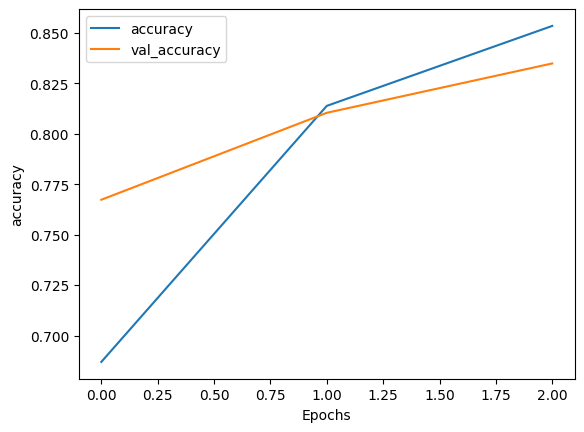

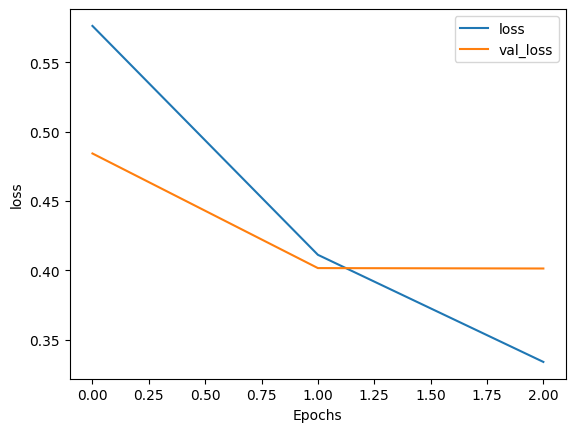

Running without additional features...
Using Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
Using Pretrained Model: vinai/bertweet-base


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Training model...
Epoch 1/3
761/761 [==============================] - 187s 173ms/step - loss: 0.6605 - accuracy: 0.5954 - val_loss: 0.5582 - val_accuracy: 0.7158
Epoch 2/3
761/761 [==============================] - 120s 158ms/step - loss: 0.5001 - accuracy: 0.7611 - val_loss: 0.4089 - val_accuracy: 0.8118
Epoch 3/3
761/761 [==============================] - 119s 157ms/step - loss: 0.3941 - accuracy: 0.8229 - val_loss: 0.3737 - val_accuracy: 0.8316
Evaluating model...
135/135 [==============================] - 18s 59ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.80      0.90      0.85      2248
    Sarcastic       0.88      0.75      0.81      2045

     accuracy                           0.83      4293
    macro avg       0.84      0.83      0.83      4293
 weighted avg       0.84      0.83      0.83      4293



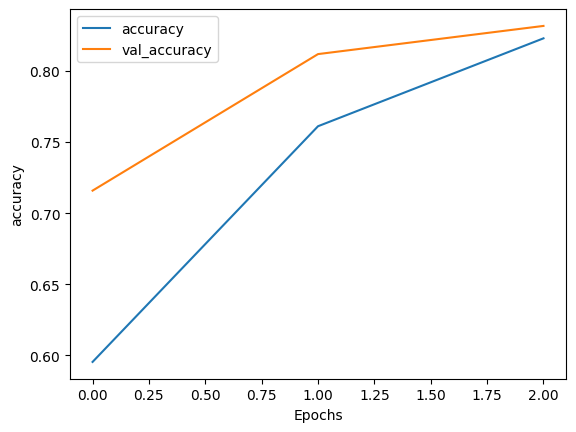

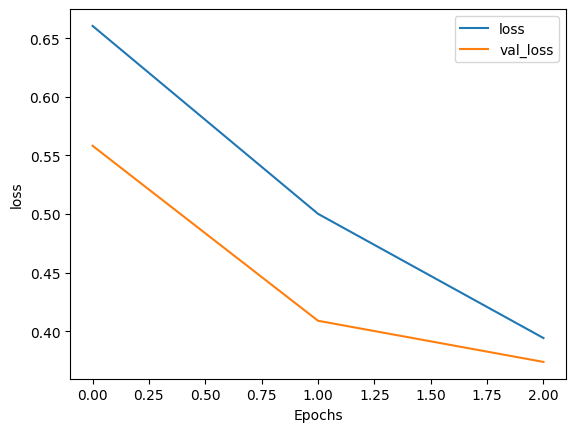

Running without additional features...
Using Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
Using Pretrained Model: xlnet-base-cased


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/565M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNe

Training model...
Epoch 1/3
761/761 [==============================] - 184s 180ms/step - loss: 0.6787 - accuracy: 0.5927 - val_loss: 0.5678 - val_accuracy: 0.6923
Epoch 2/3
761/761 [==============================] - 128s 169ms/step - loss: 0.5356 - accuracy: 0.7314 - val_loss: 0.4695 - val_accuracy: 0.7792
Epoch 3/3
761/761 [==============================] - 128s 169ms/step - loss: 0.4497 - accuracy: 0.7892 - val_loss: 0.4203 - val_accuracy: 0.8043
Evaluating model...
135/135 [==============================] - 15s 57ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.81      0.82      0.81      2248
    Sarcastic       0.80      0.78      0.79      2045

     accuracy                           0.80      4293
    macro avg       0.80      0.80      0.80      4293
 weighted avg       0.80      0.80      0.80      4293



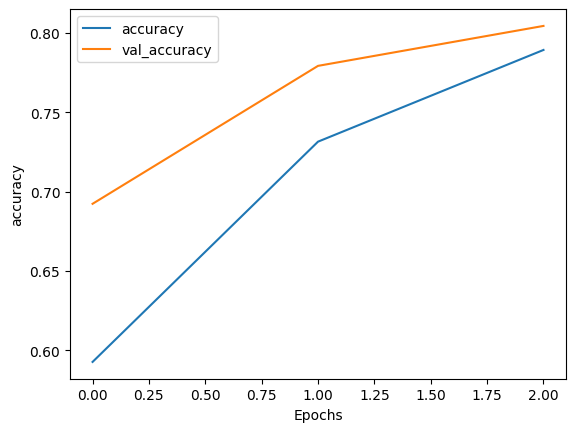

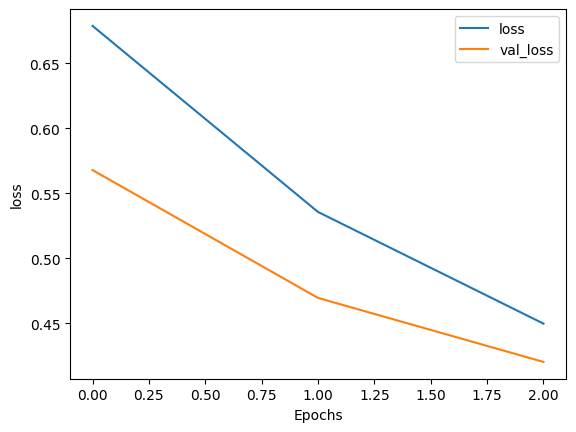

Running without additional features...
Using Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
Using Pretrained Model: gpt2


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


Training model...
Epoch 1/3
761/761 [==============================] - 157s 150ms/step - loss: 0.7960 - accuracy: 0.5004 - val_loss: 0.6856 - val_accuracy: 0.5292
Epoch 2/3
761/761 [==============================] - 106s 139ms/step - loss: 0.6897 - accuracy: 0.5431 - val_loss: 0.6647 - val_accuracy: 0.5812
Epoch 3/3
761/761 [==============================] - 106s 139ms/step - loss: 0.6556 - accuracy: 0.5962 - val_loss: 0.6455 - val_accuracy: 0.6152
Evaluating model...
135/135 [==============================] - 13s 44ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.58      0.95      0.72      2248
    Sarcastic       0.81      0.25      0.38      2045

     accuracy                           0.62      4293
    macro avg       0.70      0.60      0.55      4293
 weighted avg       0.69      0.62      0.56      4293



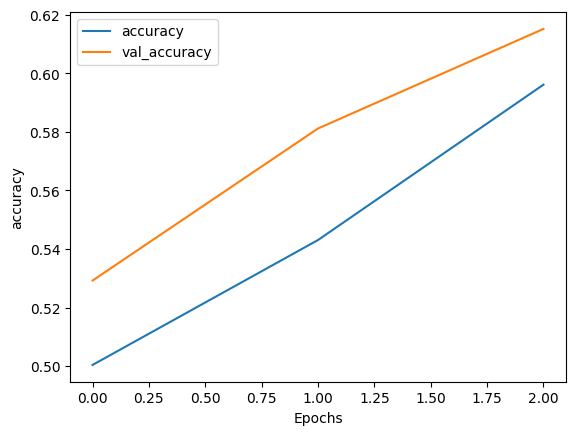

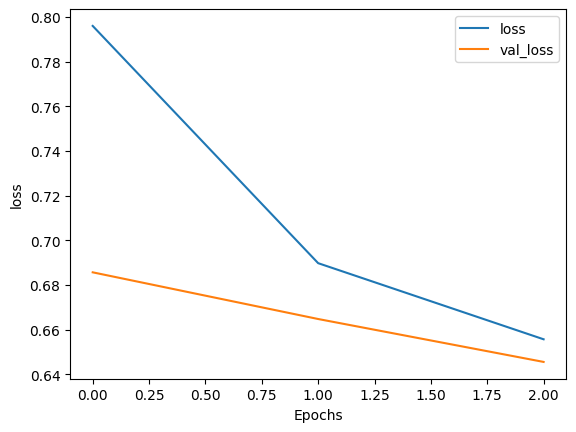

Running without additional features...
Using Dataset: ../input/rilloff/riloff_dataset.json
Using Pretrained Model: roberta-base


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Training model...
Epoch 1/3
52/52 [==============================] - 74s 376ms/step - loss: 0.5300 - accuracy: 0.7876 - val_loss: 0.4518 - val_accuracy: 0.8435
Epoch 2/3
52/52 [==============================] - 9s 164ms/step - loss: 0.4584 - accuracy: 0.8424 - val_loss: 0.4280 - val_accuracy: 0.8435
Epoch 3/3
52/52 [==============================] - 8s 160ms/step - loss: 0.4410 - accuracy: 0.8424 - val_loss: 0.4065 - val_accuracy: 0.8435
Evaluating model...
10/10 [==============================] - 10s 55ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.84      1.00      0.92       248
    Sarcastic       0.00      0.00      0.00        46

     accuracy                           0.84       294
    macro avg       0.42      0.50      0.46       294
 weighted avg       0.71      0.84      0.77       294



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


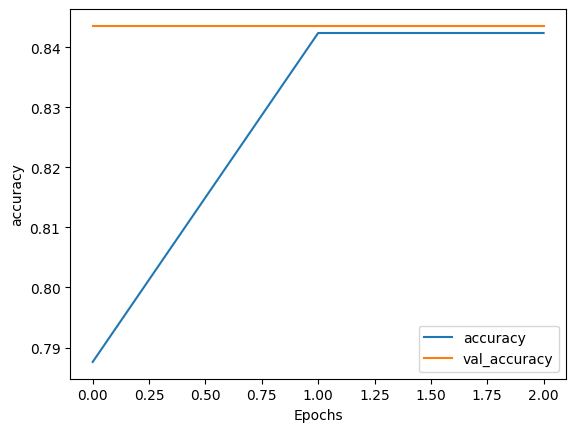

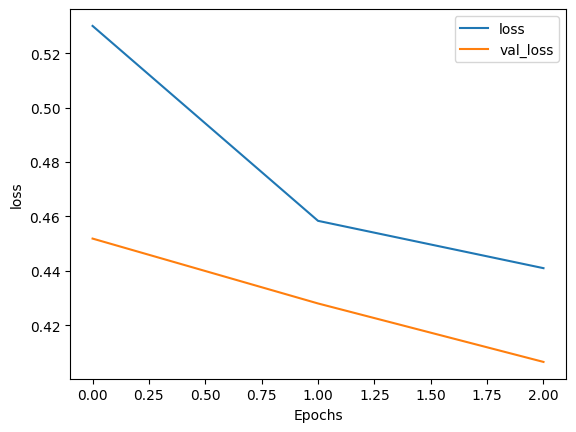

Running without additional features...
Using Dataset: ../input/rilloff/riloff_dataset.json
Using Pretrained Model: vinai/bertweet-base


Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Training model...
Epoch 1/3
52/52 [==============================] - 76s 379ms/step - loss: 0.4546 - accuracy: 0.8333 - val_loss: 0.4383 - val_accuracy: 0.8435
Epoch 2/3
52/52 [==============================] - 8s 164ms/step - loss: 0.4424 - accuracy: 0.8424 - val_loss: 0.4365 - val_accuracy: 0.8435
Epoch 3/3
52/52 [==============================] - 9s 164ms/step - loss: 0.4391 - accuracy: 0.8424 - val_loss: 0.4375 - val_accuracy: 0.8435
Evaluating model...
10/10 [==============================] - 10s 55ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.84      1.00      0.92       248
    Sarcastic       0.00      0.00      0.00        46

     accuracy                           0.84       294
    macro avg       0.42      0.50      0.46       294
 weighted avg       0.71      0.84      0.77       294



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


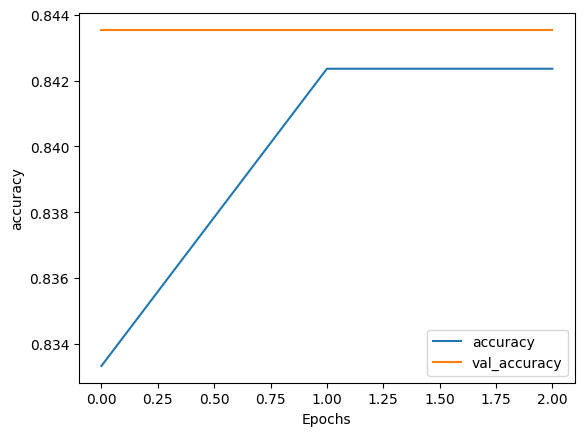

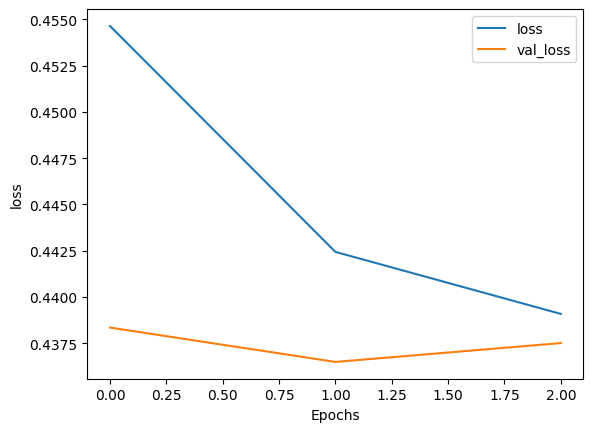

Running without additional features...
Using Dataset: ../input/rilloff/riloff_dataset.json
Using Pretrained Model: xlnet-base-cased


/opt/conda/lib/python3.10/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNe

Training model...
Epoch 1/3
52/52 [==============================] - 64s 323ms/step - loss: 0.5545 - accuracy: 0.8111 - val_loss: 0.4364 - val_accuracy: 0.8435
Epoch 2/3
52/52 [==============================] - 9s 175ms/step - loss: 0.4546 - accuracy: 0.8400 - val_loss: 0.4276 - val_accuracy: 0.8435
Epoch 3/3
52/52 [==============================] - 9s 174ms/step - loss: 0.4458 - accuracy: 0.8424 - val_loss: 0.4531 - val_accuracy: 0.8435
Evaluating model...
10/10 [==============================] - 8s 54ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.84      1.00      0.92       248
    Sarcastic       0.00      0.00      0.00        46

     accuracy                           0.84       294
    macro avg       0.42      0.50      0.46       294
 weighted avg       0.71      0.84      0.77       294



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


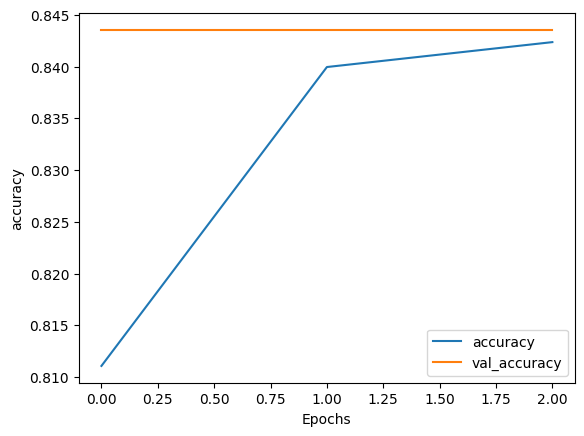

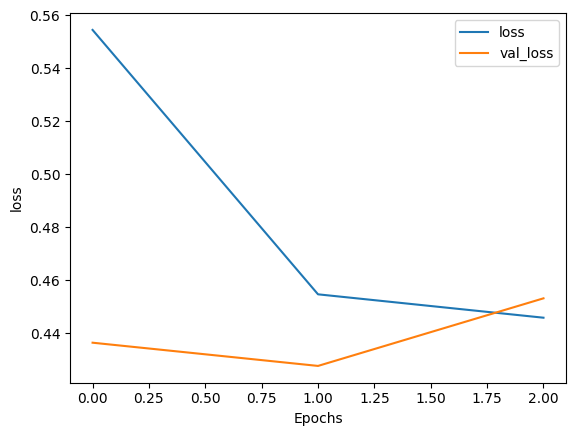

Running without additional features...
Using Dataset: ../input/rilloff/riloff_dataset.json
Using Pretrained Model: gpt2


All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


Training model...
Epoch 1/3
52/52 [==============================] - 59s 328ms/step - loss: 0.8648 - accuracy: 0.6637 - val_loss: 0.5005 - val_accuracy: 0.8435
Epoch 2/3
52/52 [==============================] - 8s 145ms/step - loss: 0.5560 - accuracy: 0.7864 - val_loss: 0.4413 - val_accuracy: 0.8435
Epoch 3/3
52/52 [==============================] - 7s 144ms/step - loss: 0.5202 - accuracy: 0.7960 - val_loss: 0.4363 - val_accuracy: 0.8435
Evaluating model...
10/10 [==============================] - 8s 44ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.84      1.00      0.92       248
    Sarcastic       0.00      0.00      0.00        46

     accuracy                           0.84       294
    macro avg       0.42      0.50      0.46       294
 weighted avg       0.71      0.84      0.77       294



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


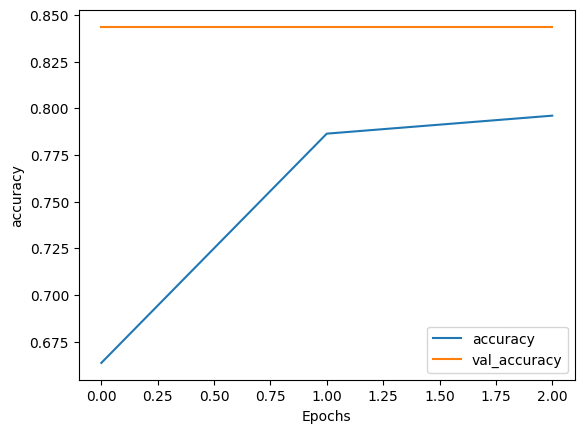

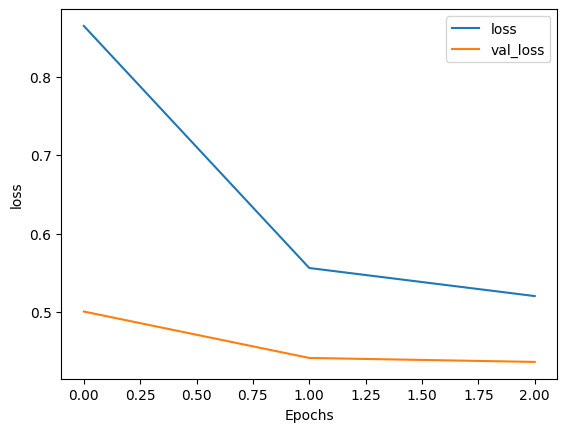

Running without additional features...
Using Dataset: ../input/ghoshdata/sarcasm_dataset.json
Using Pretrained Model: roberta-base


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Training model...
Epoch 1/3
1460/1460 [==============================] - 296s 164ms/step - loss: 0.6518 - accuracy: 0.5973 - val_loss: 0.5818 - val_accuracy: 0.6945
Epoch 2/3
1460/1460 [==============================] - 228s 156ms/step - loss: 0.5527 - accuracy: 0.7138 - val_loss: 0.5318 - val_accuracy: 0.7343
Epoch 3/3
1460/1460 [==============================] - 229s 157ms/step - loss: 0.4809 - accuracy: 0.7683 - val_loss: 0.5046 - val_accuracy: 0.7535
Evaluating model...
258/258 [==============================] - 25s 59ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.77      0.76      0.77      4359
    Sarcastic       0.74      0.74      0.74      3881

     accuracy                           0.75      8240
    macro avg       0.75      0.75      0.75      8240
 weighted avg       0.75      0.75      0.75      8240



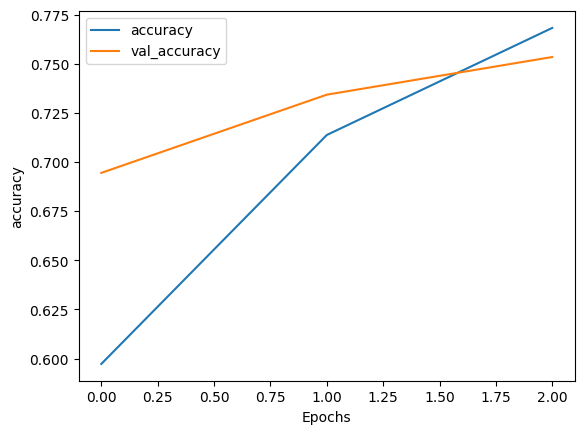

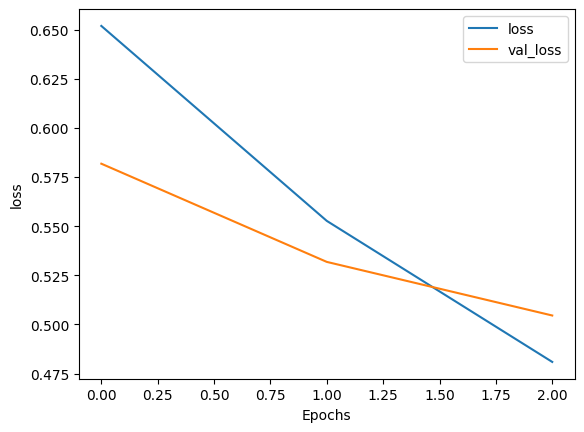

Running without additional features...
Using Dataset: ../input/ghoshdata/sarcasm_dataset.json
Using Pretrained Model: vinai/bertweet-base


Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Training model...
Epoch 1/3
1460/1460 [==============================] - 299s 166ms/step - loss: 0.6606 - accuracy: 0.5839 - val_loss: 0.5791 - val_accuracy: 0.6930
Epoch 2/3
1460/1460 [==============================] - 229s 157ms/step - loss: 0.5756 - accuracy: 0.6943 - val_loss: 0.5460 - val_accuracy: 0.7206
Epoch 3/3
1460/1460 [==============================] - 228s 156ms/step - loss: 0.5146 - accuracy: 0.7407 - val_loss: 0.5096 - val_accuracy: 0.7487
Evaluating model...
258/258 [==============================] - 24s 58ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.73      0.83      0.78      4359
    Sarcastic       0.77      0.66      0.71      3881

     accuracy                           0.75      8240
    macro avg       0.75      0.74      0.74      8240
 weighted avg       0.75      0.75      0.75      8240



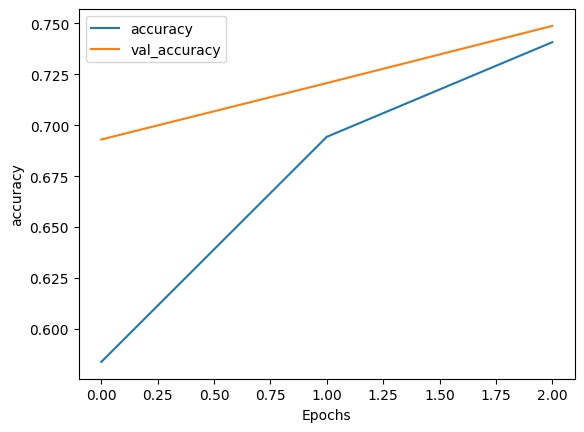

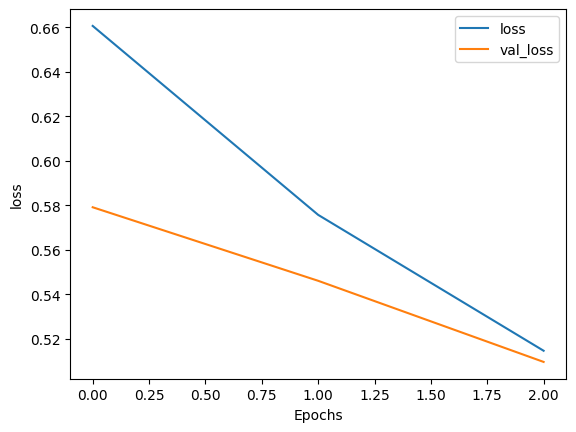

Running without additional features...
Using Dataset: ../input/ghoshdata/sarcasm_dataset.json
Using Pretrained Model: xlnet-base-cased


/opt/conda/lib/python3.10/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNe

Training model...
Epoch 1/3
1460/1460 [==============================] - 302s 175ms/step - loss: 0.7046 - accuracy: 0.5129 - val_loss: 0.6917 - val_accuracy: 0.5290
Epoch 2/3
1460/1460 [==============================] - 246s 169ms/step - loss: 0.6923 - accuracy: 0.5227 - val_loss: 0.6915 - val_accuracy: 0.5290
Epoch 3/3
1460/1460 [==============================] - 247s 169ms/step - loss: 0.6797 - accuracy: 0.5556 - val_loss: 0.6552 - val_accuracy: 0.6300
Evaluating model...
258/258 [==============================] - 22s 56ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.72      0.49      0.58      4359
    Sarcastic       0.58      0.79      0.67      3881

     accuracy                           0.63      8240
    macro avg       0.65      0.64      0.63      8240
 weighted avg       0.65      0.63      0.62      8240



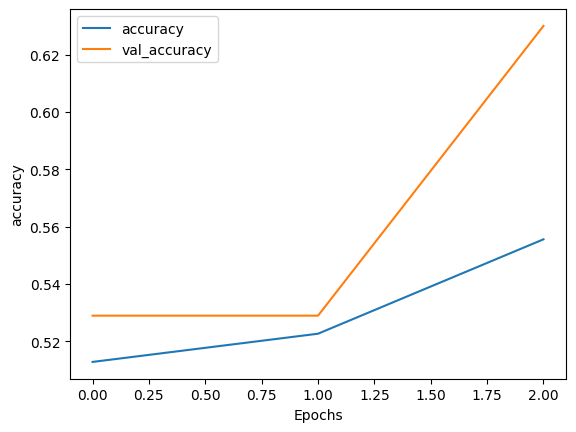

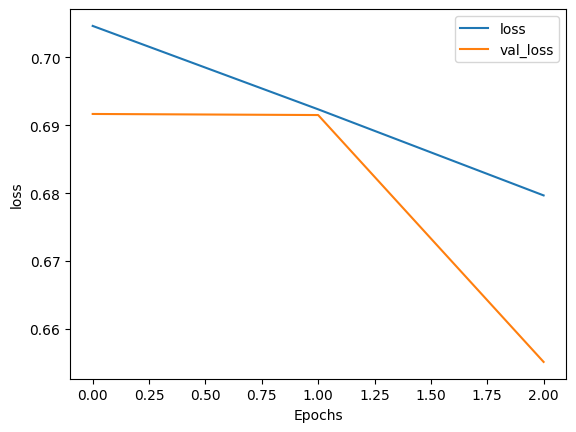

Running without additional features...
Using Dataset: ../input/ghoshdata/sarcasm_dataset.json
Using Pretrained Model: gpt2


All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


Training model...
Epoch 1/3
1460/1460 [==============================] - 254s 145ms/step - loss: 0.7290 - accuracy: 0.5321 - val_loss: 0.6796 - val_accuracy: 0.5414
Epoch 2/3
1460/1460 [==============================] - 204s 140ms/step - loss: 0.6710 - accuracy: 0.5681 - val_loss: 0.6773 - val_accuracy: 0.5232
Epoch 3/3
1460/1460 [==============================] - 204s 139ms/step - loss: 0.6625 - accuracy: 0.5792 - val_loss: 0.6588 - val_accuracy: 0.5811
Evaluating model...
258/258 [==============================] - 18s 43ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.59      0.70      0.64      4359
    Sarcastic       0.57      0.44      0.50      3881

     accuracy                           0.58      8240
    macro avg       0.58      0.57      0.57      8240
 weighted avg       0.58      0.58      0.57      8240



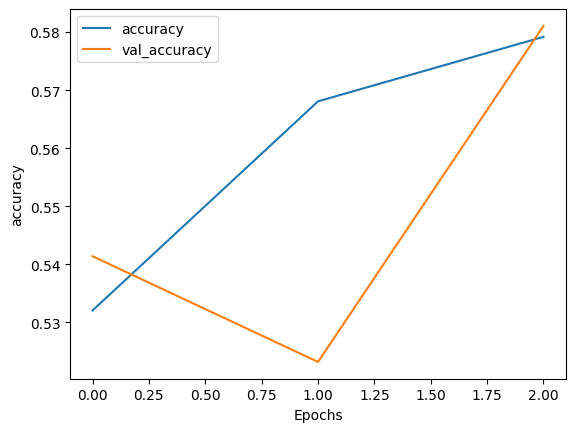

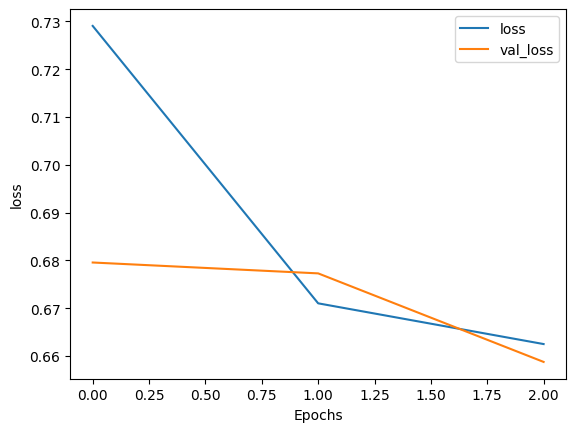

In [6]:
# Run Experiments
datasets = ["../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json",
            "../input/rilloff/riloff_dataset.json",
            "../input/ghoshdata/sarcasm_dataset.json"
           ]
pretrained_models = ['roberta-base', 'vinai/bertweet-base', 'xlnet-base-cased', 'gpt2']

# Without Features
for dataset in datasets:
    for model_name in pretrained_models:
        print("Running without additional features...")
        main(dataset, model_name, use_features=False)

Running with additional features... | Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json | Model: roberta-base
Using Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
Using Pretrained Model: roberta-base


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Training model...
Epoch 1/3
761/761 [==============================] - 182s 169ms/step - loss: 0.5994 - accuracy: 0.6606 - val_loss: 0.4309 - val_accuracy: 0.8032
Epoch 2/3
761/761 [==============================] - 118s 156ms/step - loss: 0.4226 - accuracy: 0.8028 - val_loss: 0.3825 - val_accuracy: 0.8309
Epoch 3/3
761/761 [==============================] - 118s 156ms/step - loss: 0.3405 - accuracy: 0.8507 - val_loss: 0.3908 - val_accuracy: 0.8323
Evaluating model...
135/135 [==============================] - 17s 58ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.88      0.78      0.83      2248
    Sarcastic       0.79      0.89      0.83      2045

     accuracy                           0.83      4293
    macro avg       0.84      0.83      0.83      4293
 weighted avg       0.84      0.83      0.83      4293



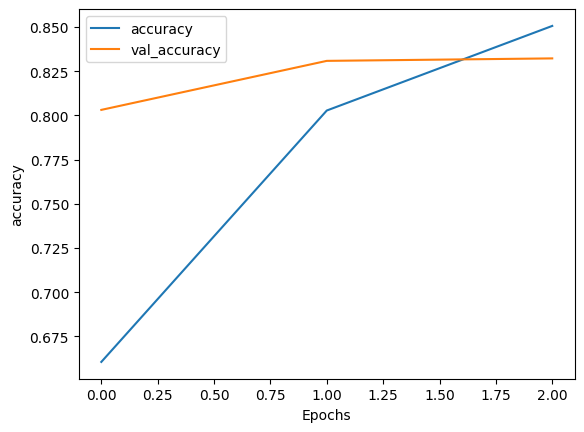

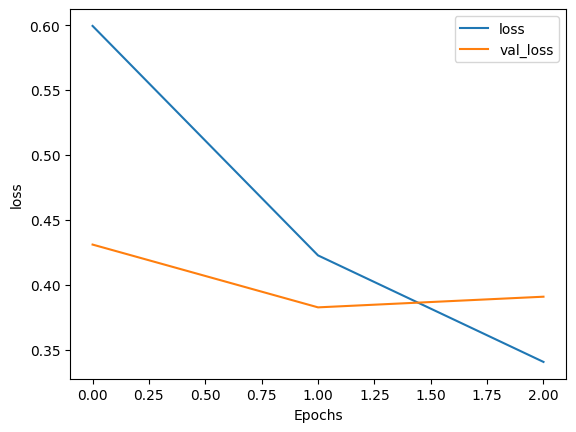

Running with additional features... | Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json | Model: vinai/bertweet-base
Using Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
Using Pretrained Model: vinai/bertweet-base


Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Training model...
Epoch 1/3
761/761 [==============================] - 187s 174ms/step - loss: 0.6390 - accuracy: 0.6250 - val_loss: 0.5211 - val_accuracy: 0.7638
Epoch 2/3
761/761 [==============================] - 120s 158ms/step - loss: 0.5381 - accuracy: 0.7322 - val_loss: 0.5143 - val_accuracy: 0.7531
Epoch 3/3
761/761 [==============================] - 120s 158ms/step - loss: 0.4157 - accuracy: 0.8100 - val_loss: 0.3570 - val_accuracy: 0.8411
Evaluating model...
135/135 [==============================] - 18s 58ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.82      0.89      0.85      2248
    Sarcastic       0.87      0.79      0.83      2045

     accuracy                           0.84      4293
    macro avg       0.84      0.84      0.84      4293
 weighted avg       0.84      0.84      0.84      4293



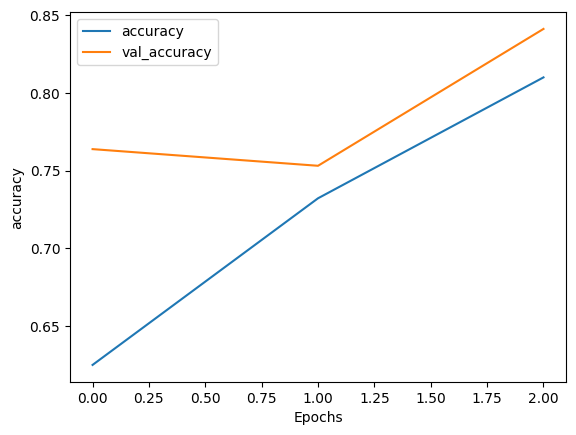

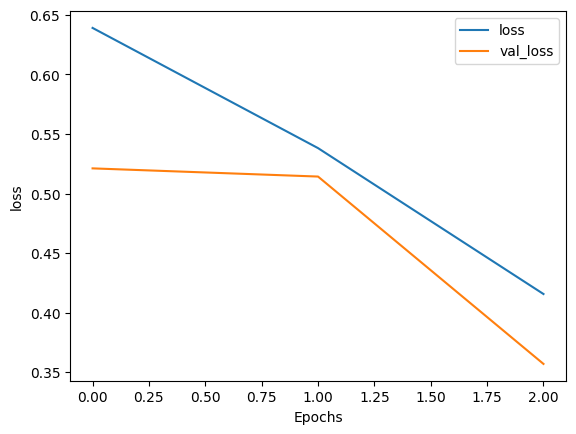

Running with additional features... | Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json | Model: xlnet-base-cased
Using Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
Using Pretrained Model: xlnet-base-cased


/opt/conda/lib/python3.10/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNe

Training model...
Epoch 1/3
761/761 [==============================] - 184s 180ms/step - loss: 0.6708 - accuracy: 0.5956 - val_loss: 0.5545 - val_accuracy: 0.7137
Epoch 2/3
761/761 [==============================] - 129s 170ms/step - loss: 0.5205 - accuracy: 0.7406 - val_loss: 0.4775 - val_accuracy: 0.7629
Epoch 3/3
761/761 [==============================] - 129s 170ms/step - loss: 0.4330 - accuracy: 0.7991 - val_loss: 0.4330 - val_accuracy: 0.7897
Evaluating model...
135/135 [==============================] - 15s 57ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.80      0.80      0.80      2248
    Sarcastic       0.78      0.78      0.78      2045

     accuracy                           0.79      4293
    macro avg       0.79      0.79      0.79      4293
 weighted avg       0.79      0.79      0.79      4293



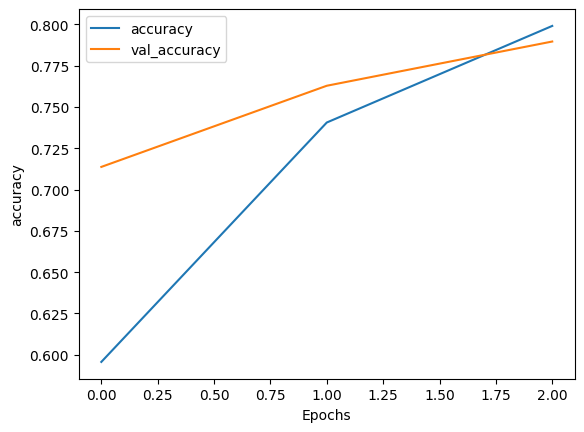

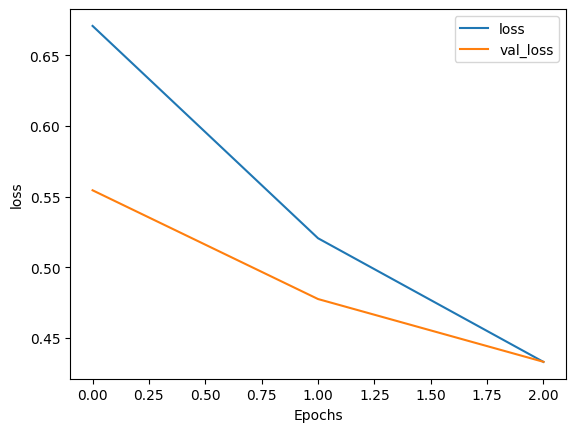

Running with additional features... | Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json | Model: gpt2
Using Dataset: ../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
Using Pretrained Model: gpt2


All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


Training model...
Epoch 1/3
761/761 [==============================] - 157s 150ms/step - loss: 0.7717 - accuracy: 0.5245 - val_loss: 0.6933 - val_accuracy: 0.5080
Epoch 2/3
761/761 [==============================] - 106s 140ms/step - loss: 0.6798 - accuracy: 0.5631 - val_loss: 0.6587 - val_accuracy: 0.6019
Epoch 3/3
761/761 [==============================] - 106s 139ms/step - loss: 0.6480 - accuracy: 0.6056 - val_loss: 0.6299 - val_accuracy: 0.6136
Evaluating model...
135/135 [==============================] - 13s 44ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.65      0.56      0.60      2248
    Sarcastic       0.58      0.67      0.62      2045

     accuracy                           0.61      4293
    macro avg       0.62      0.62      0.61      4293
 weighted avg       0.62      0.61      0.61      4293



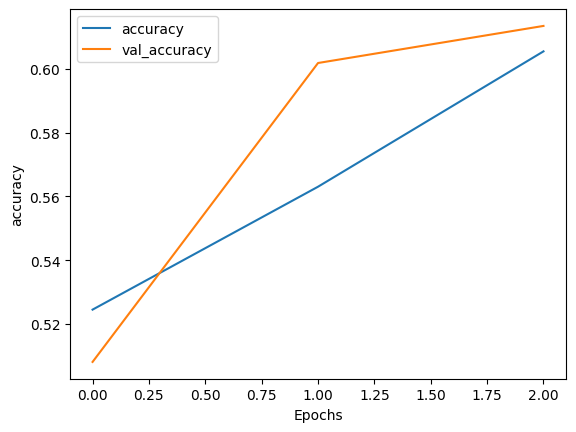

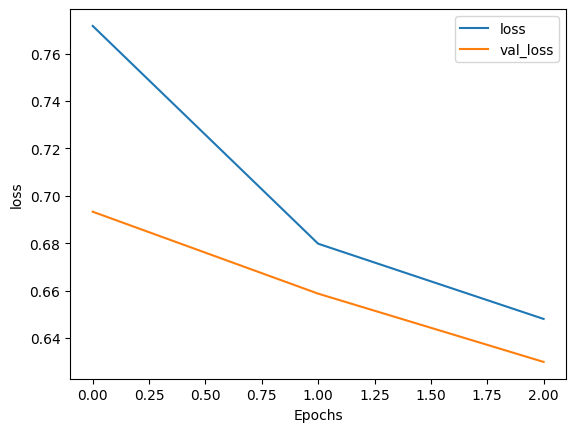

Running with additional features... | Dataset: ../input/rilloff/riloff_dataset.json | Model: roberta-base
Using Dataset: ../input/rilloff/riloff_dataset.json
Using Pretrained Model: roberta-base


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Training model...
Epoch 1/3
52/52 [==============================] - 73s 360ms/step - loss: 0.4614 - accuracy: 0.8225 - val_loss: 0.3907 - val_accuracy: 0.8435
Epoch 2/3
52/52 [==============================] - 8s 164ms/step - loss: 0.4210 - accuracy: 0.8424 - val_loss: 0.3251 - val_accuracy: 0.8878
Epoch 3/3
52/52 [==============================] - 8s 161ms/step - loss: 0.3023 - accuracy: 0.8785 - val_loss: 0.2207 - val_accuracy: 0.9116
Evaluating model...
10/10 [==============================] - 10s 55ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.98      0.91      0.95       248
    Sarcastic       0.66      0.91      0.76        46

     accuracy                           0.91       294
    macro avg       0.82      0.91      0.85       294
 weighted avg       0.93      0.91      0.92       294



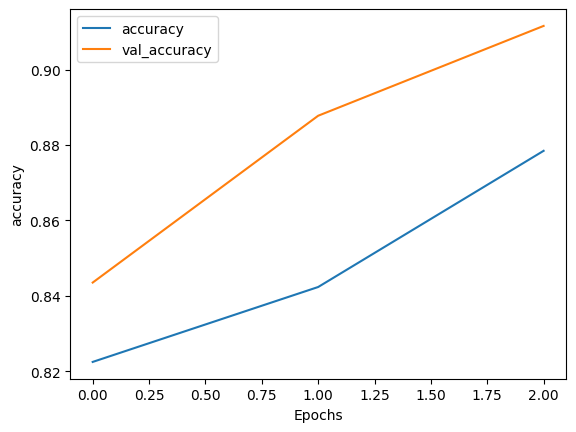

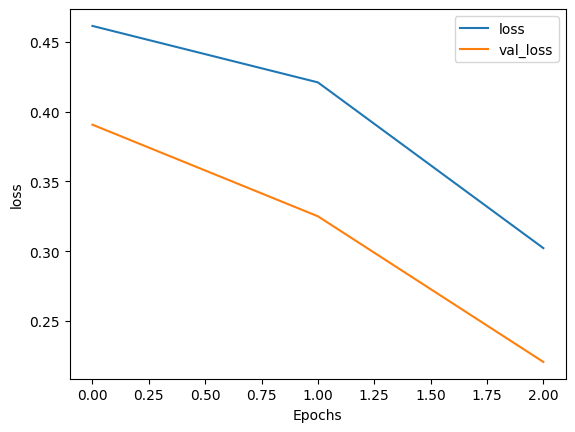

Running with additional features... | Dataset: ../input/rilloff/riloff_dataset.json | Model: vinai/bertweet-base
Using Dataset: ../input/rilloff/riloff_dataset.json
Using Pretrained Model: vinai/bertweet-base


Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Training model...
Epoch 1/3
52/52 [==============================] - 76s 376ms/step - loss: 0.6235 - accuracy: 0.6751 - val_loss: 0.4452 - val_accuracy: 0.8333
Epoch 2/3
52/52 [==============================] - 9s 165ms/step - loss: 0.4484 - accuracy: 0.8387 - val_loss: 0.4263 - val_accuracy: 0.8435
Epoch 3/3
52/52 [==============================] - 9s 165ms/step - loss: 0.4297 - accuracy: 0.8424 - val_loss: 0.4173 - val_accuracy: 0.8435
Evaluating model...
10/10 [==============================] - 10s 56ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.84      1.00      0.92       248
    Sarcastic       0.00      0.00      0.00        46

     accuracy                           0.84       294
    macro avg       0.42      0.50      0.46       294
 weighted avg       0.71      0.84      0.77       294



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


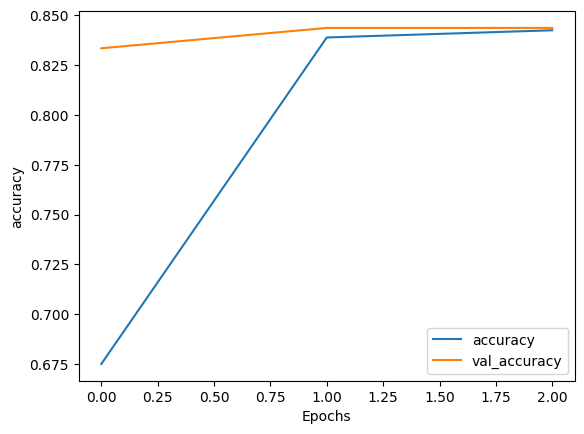

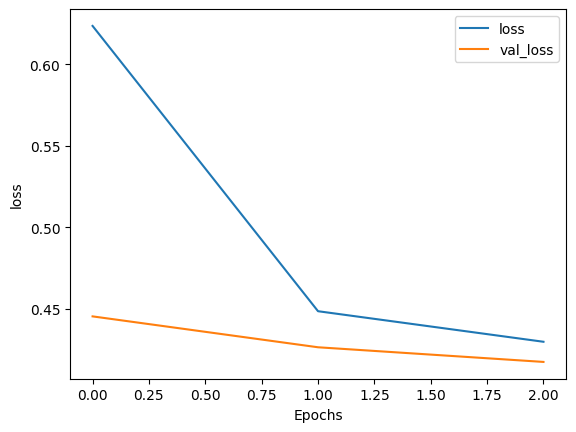

Running with additional features... | Dataset: ../input/rilloff/riloff_dataset.json | Model: xlnet-base-cased
Using Dataset: ../input/rilloff/riloff_dataset.json
Using Pretrained Model: xlnet-base-cased


/opt/conda/lib/python3.10/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNe

Training model...
Epoch 1/3
52/52 [==============================] - 65s 325ms/step - loss: 0.5571 - accuracy: 0.8063 - val_loss: 0.4203 - val_accuracy: 0.8435
Epoch 2/3
52/52 [==============================] - 9s 176ms/step - loss: 0.4431 - accuracy: 0.8394 - val_loss: 0.3847 - val_accuracy: 0.8435
Epoch 3/3
52/52 [==============================] - 9s 174ms/step - loss: 0.4170 - accuracy: 0.8442 - val_loss: 0.3928 - val_accuracy: 0.8537
Evaluating model...
10/10 [==============================] - 8s 53ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.85      1.00      0.92       248
    Sarcastic       0.80      0.09      0.16        46

     accuracy                           0.85       294
    macro avg       0.83      0.54      0.54       294
 weighted avg       0.85      0.85      0.80       294



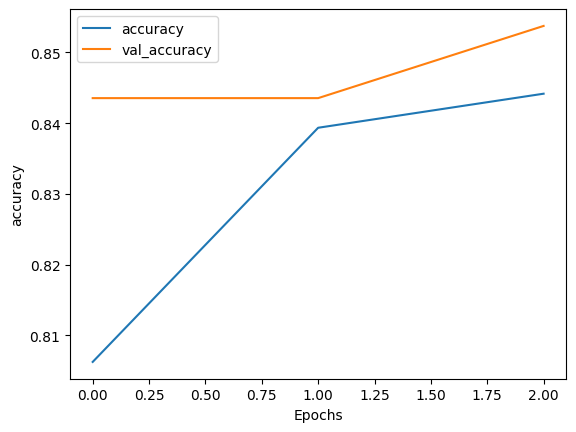

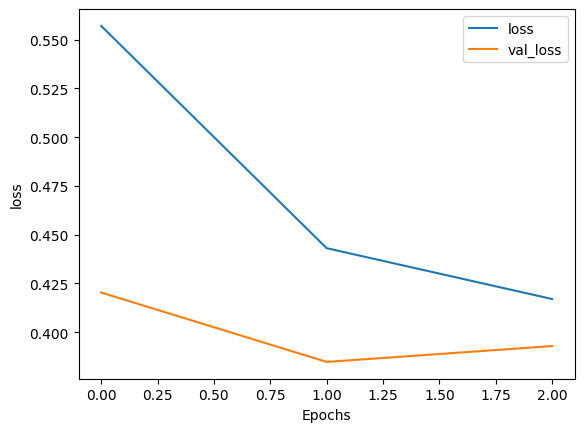

Running with additional features... | Dataset: ../input/rilloff/riloff_dataset.json | Model: gpt2
Using Dataset: ../input/rilloff/riloff_dataset.json
Using Pretrained Model: gpt2


All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


Training model...
Epoch 1/3
52/52 [==============================] - 61s 310ms/step - loss: 0.9596 - accuracy: 0.6805 - val_loss: 0.4833 - val_accuracy: 0.8435
Epoch 2/3
52/52 [==============================] - 8s 146ms/step - loss: 0.5491 - accuracy: 0.7599 - val_loss: 0.4253 - val_accuracy: 0.8435
Epoch 3/3
52/52 [==============================] - 8s 145ms/step - loss: 0.5187 - accuracy: 0.7924 - val_loss: 0.4233 - val_accuracy: 0.8435
Evaluating model...
10/10 [==============================] - 8s 44ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.84      1.00      0.92       248
    Sarcastic       0.00      0.00      0.00        46

     accuracy                           0.84       294
    macro avg       0.42      0.50      0.46       294
 weighted avg       0.71      0.84      0.77       294



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


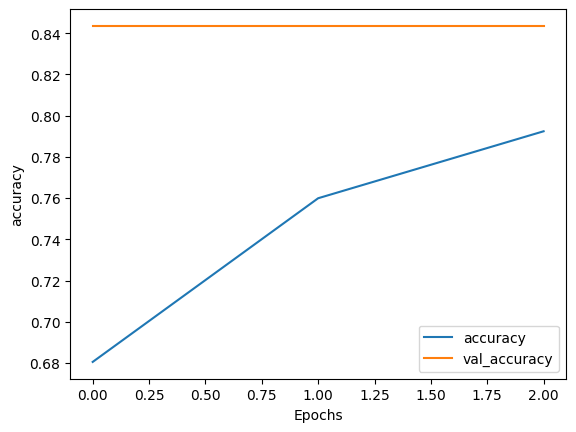

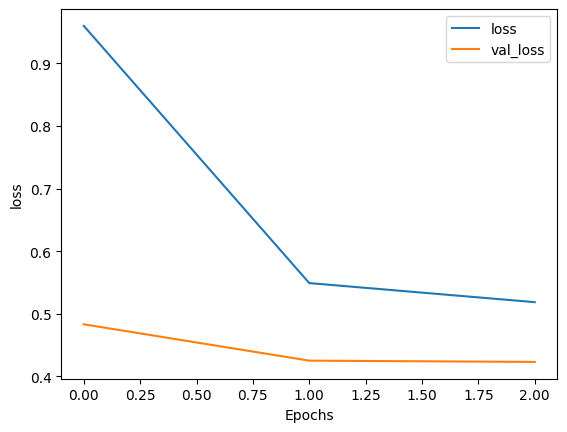

Running with additional features... | Dataset: ../input/ghoshdata/sarcasm_dataset.json | Model: roberta-base
Using Dataset: ../input/ghoshdata/sarcasm_dataset.json
Using Pretrained Model: roberta-base


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Training model...
Epoch 1/3
1460/1460 [==============================] - 297s 165ms/step - loss: 0.6083 - accuracy: 0.6749 - val_loss: 0.5143 - val_accuracy: 0.7441
Epoch 2/3
1460/1460 [==============================] - 229s 157ms/step - loss: 0.4990 - accuracy: 0.7604 - val_loss: 0.4541 - val_accuracy: 0.7881
Epoch 3/3
1460/1460 [==============================] - 230s 157ms/step - loss: 0.4319 - accuracy: 0.8044 - val_loss: 0.4609 - val_accuracy: 0.7828
Evaluating model...
258/258 [==============================] - 26s 60ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.75      0.90      0.81      4359
    Sarcastic       0.85      0.66      0.74      3881

     accuracy                           0.78      8240
    macro avg       0.80      0.78      0.78      8240
 weighted avg       0.79      0.78      0.78      8240



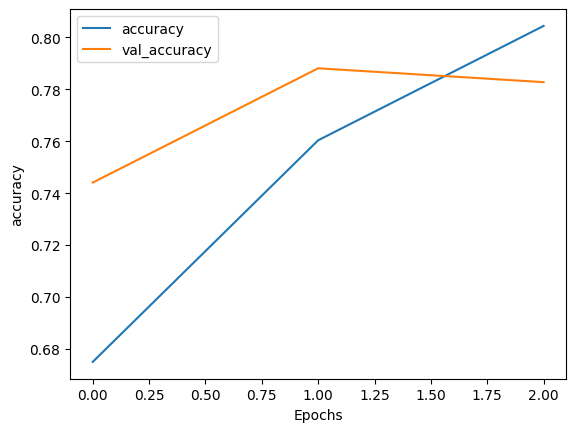

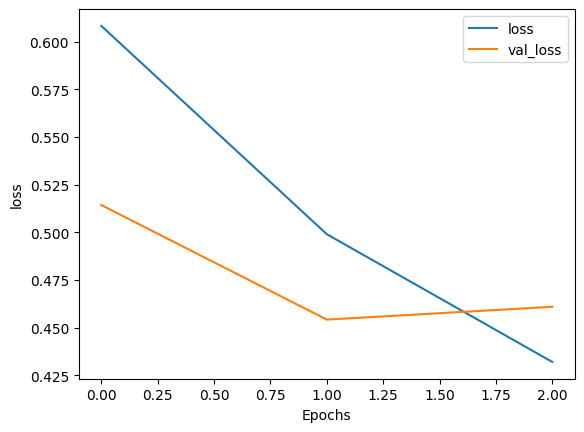

Running with additional features... | Dataset: ../input/ghoshdata/sarcasm_dataset.json | Model: vinai/bertweet-base
Using Dataset: ../input/ghoshdata/sarcasm_dataset.json
Using Pretrained Model: vinai/bertweet-base


Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Training model...
Epoch 1/3
1460/1460 [==============================] - 302s 167ms/step - loss: 0.6537 - accuracy: 0.6439 - val_loss: 0.6273 - val_accuracy: 0.6306
Epoch 2/3
1460/1460 [==============================] - 230s 157ms/step - loss: 0.6251 - accuracy: 0.6932 - val_loss: 0.6105 - val_accuracy: 0.6504
Epoch 3/3
1460/1460 [==============================] - 229s 157ms/step - loss: 0.6043 - accuracy: 0.7120 - val_loss: 0.5965 - val_accuracy: 0.7107
Evaluating model...
258/258 [==============================] - 25s 58ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.67      0.90      0.77      4359
    Sarcastic       0.82      0.50      0.62      3881

     accuracy                           0.71      8240
    macro avg       0.74      0.70      0.69      8240
 weighted avg       0.74      0.71      0.70      8240



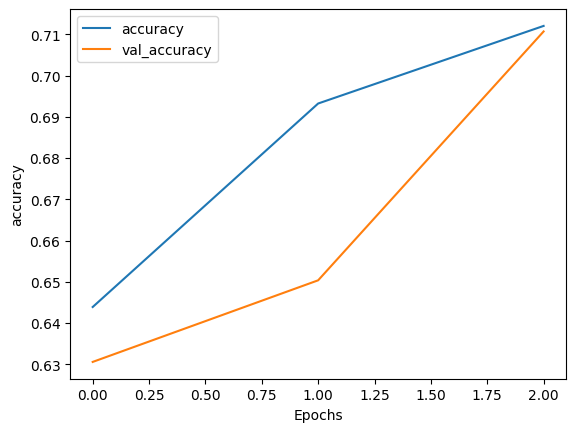

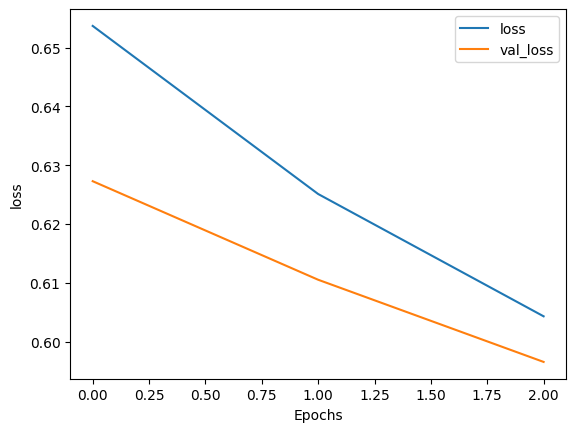

Running with additional features... | Dataset: ../input/ghoshdata/sarcasm_dataset.json | Model: xlnet-base-cased
Using Dataset: ../input/ghoshdata/sarcasm_dataset.json
Using Pretrained Model: xlnet-base-cased


/opt/conda/lib/python3.10/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNe

Training model...
Epoch 1/3
1460/1460 [==============================] - 301s 174ms/step - loss: 0.6589 - accuracy: 0.6150 - val_loss: 0.5598 - val_accuracy: 0.7073
Epoch 2/3
1460/1460 [==============================] - 246s 169ms/step - loss: 0.5497 - accuracy: 0.7214 - val_loss: 0.4885 - val_accuracy: 0.7564
Epoch 3/3
1460/1460 [==============================] - 246s 168ms/step - loss: 0.4759 - accuracy: 0.7743 - val_loss: 0.4554 - val_accuracy: 0.7882
Evaluating model...
258/258 [==============================] - 21s 57ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.78      0.83      0.81      4359
    Sarcastic       0.80      0.74      0.77      3881

     accuracy                           0.79      8240
    macro avg       0.79      0.79      0.79      8240
 weighted avg       0.79      0.79      0.79      8240



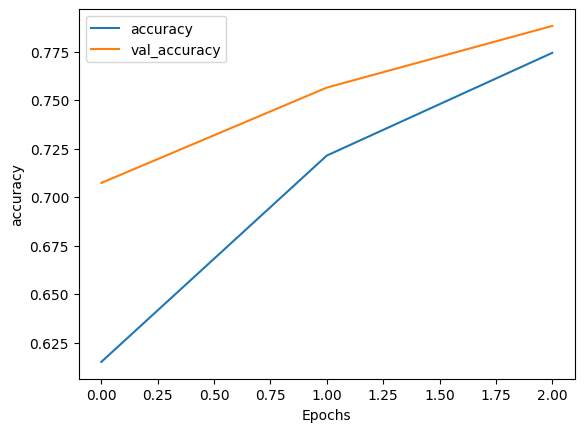

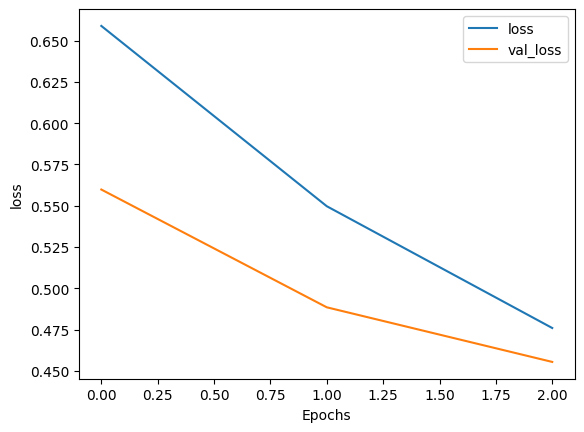

Running with additional features... | Dataset: ../input/ghoshdata/sarcasm_dataset.json | Model: gpt2
Using Dataset: ../input/ghoshdata/sarcasm_dataset.json
Using Pretrained Model: gpt2


All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


Training model...
Epoch 1/3
1460/1460 [==============================] - 255s 146ms/step - loss: 0.7188 - accuracy: 0.5776 - val_loss: 0.6357 - val_accuracy: 0.6921
Epoch 2/3
1460/1460 [==============================] - 204s 140ms/step - loss: 0.6181 - accuracy: 0.6801 - val_loss: 0.6014 - val_accuracy: 0.6941
Epoch 3/3
1460/1460 [==============================] - 204s 140ms/step - loss: 0.5860 - accuracy: 0.7159 - val_loss: 0.5769 - val_accuracy: 0.7368
Evaluating model...
258/258 [==============================] - 18s 44ms/step

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.71      0.86      0.77      4359
    Sarcastic       0.79      0.60      0.68      3881

     accuracy                           0.74      8240
    macro avg       0.75      0.73      0.73      8240
 weighted avg       0.75      0.74      0.73      8240



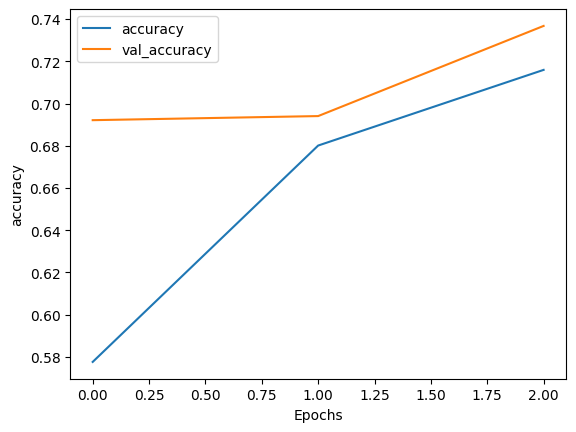

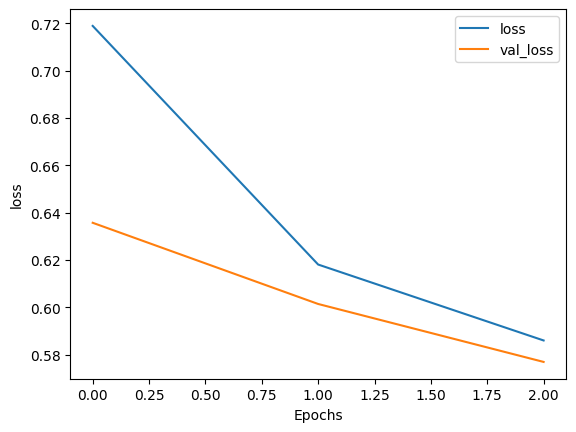

In [7]:
# Run Experiments
datasets = ["../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json",
            "../input/rilloff/riloff_dataset.json",
            "../input/ghoshdata/sarcasm_dataset.json"
           ]
pretrained_models = ['roberta-base', 'vinai/bertweet-base', 'xlnet-base-cased', 'gpt2']

# With Features
for dataset in datasets:
    for model_name in pretrained_models:
        print(f"Running with additional features... | Dataset: {dataset} | Model: {model_name}")
        main(dataset, model_name, use_features=True)